# Look at specific waves of the pandemic

In [87]:
#%reset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
from Functions import calculate_maximum_reget, add_labels_to_subplots, merge_and_rename_data, pivot_data_by_HSA, create_column_names, create_collated_weekly_data, add_changes_by_week, calculate_metrics, merge_and_rename_data, add_changes_by_week, determine_covid_outcome_indicator, prep_training_test_data_period, prep_training_test_data, prep_training_test_data_shifted, cross_validation_leave_geo_out
import random
import sklearn.metrics 
from matplotlib.patches import Polygon

#from Functions import add_labels_to_subplots, merge_and_rename_data, pivot_data_by_HSA, create_column_names, 
# create_collated_weekly_data, add_changes_by_week, prep_training_test_data_period, prep_training_test_data, 
# calculate_ppv_npv, merge_and_rename_data, add_changes_by_week, determine_covid_outcome_indicator
hfont = {'fontname':'Helvetica'}

#oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=10) #need for neural network and random forest
import pickle
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']


In [2]:
def determine_covid_outcome_indicator(
    new_cases_per_100k, new_admits_per_100k, percent_beds_100k
):
    if new_cases_per_100k < 200:
        if (new_admits_per_100k >= 10) | (percent_beds_100k > 0.10):
            if (new_admits_per_100k >= 20) | (percent_beds_100k >= 15):
                return 'High'
            else:
                return 'Medium'
        else:
            return 'Low'
    elif new_cases_per_100k >= 200:
        if (new_admits_per_100k >= 10) | (percent_beds_100k >= 0.10):
            return 'High'
        elif (new_admits_per_100k < 10) | (percent_beds_100k < 10):
            return 'High'

In [92]:
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
data_by_HSA['health_service_area_number']
data_by_HSA['health_service_area']
#data_by_HSA['HSA_ID'] = data_by_HSA['health_service_area_number'].astype(str) + '' + data_by_HSA['health_service_area'].apply(lambda x: x.split()[0])
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)

data_by_HSA['beds_over_15_100k'] = (data_by_HSA['beds_weekly'] > 15)*1

# remove HSAs that have missing data in specific columns

#data_by_HSA = data_by_HSA.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])

data_by_HSA['date'] = pd.to_datetime(data_by_HSA['date'])


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_18192/3243275868.py:1: DtypeWarning: Columns (41,43,44,45,46,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')


# Polygons for mapping onto waves

In [81]:
## County Data 


data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')

data_by_county = data_by_county.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])
data_by_county['CTYNAME'] = data_by_county['CTYNAME'].apply(lambda x: x.split()[0])
data_by_county['CTYNAME'] = data_by_county['fips'].astype(str) + '' + data_by_county['CTYNAME']
data_by_county['beds_over_15_100k'] = (data_by_county['beds_weekly'] > 15) * 1

# Redo dates
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i

## DELTA POLYGON 

start_date = pd.to_datetime('2021-06-30')
end_date = pd.to_datetime('2021-10-26')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_delta = data_by_county.loc[matching_indices_start, 'week']
last_week_delta = data_by_county.loc[matching_indices_end, 'week']
start_date = pd.to_datetime('2021-10-26')
end_date = pd.to_datetime('2022-09-27')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_omricon = data_by_county.loc[matching_indices_start, 'week']
last_week_omricon = data_by_county.loc[matching_indices_end, 'week']

## CDC POLYGON 
start_date = pd.to_datetime('2021-03-01')
end_date = pd.to_datetime('2022-01-24')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_CDC = data_by_county.loc[matching_indices_start, 'week']
last_week_CDC = data_by_county.loc[matching_indices_end, 'week']

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_16671/4200828156.py:4: DtypeWarning: Columns (47,48,49,50,51,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')


# Percent exceed capacity

In [4]:
percent_exceed_capacity = []

# Iterate through the columns of the DataFrame
for column_name in data_by_HSA.columns:
    if 'beds_over_15_100k' in column_name:
        # Calculate the sum of the column and append it to the list
        column_sum = data_by_HSA[column_name].sum()/len(data_by_HSA[column_name])
        percent_exceed_capacity.append(column_sum)

# CDC classifier period 
March 1st 2021 - Jan 24th 2022

Jan 31st 2022 - March 14th 2022 is 6 week period after

Only using the CDC classifier features

In [65]:
start_date = pd.to_datetime('2021-03-01') # full CDC period
end_date = pd.to_datetime('2022-01-24') # full CDC period
start_date = pd.to_datetime('2022-01-31')
end_date = pd.to_datetime('2022-03-14')
data_by_HSA_CDC_dates = data_by_HSA[(data_by_HSA['date'] >= start_date) & (data_by_HSA['date'] <= end_date)]



In [96]:
data_by_HSA_CDC_dates = data_by_HSA

In [97]:
for i, week in enumerate(data_by_HSA_CDC_dates['date'].unique()):
    data_by_HSA_CDC_dates.loc[data_by_HSA_CDC_dates['date'] == week, 'week'] = i

In [98]:
## pivot
data_by_HSA_CDC_dates_cases = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'cases_weekly')
data_by_HSA_CDC_dates_admissions = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'admits_weekly')
data_by_HSA_CDC_dates_percent_beds = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'perc_covid')
data_by_HSA_CDC_dates_over_15_100k = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'beds_over_15_100k')

## merge (incl outcome)
data_by_HSA_CDC_dates_cases_admits = merge_and_rename_data(data_by_HSA_CDC_dates_cases, data_by_HSA_CDC_dates_admissions,'week','cases', 'admits')

data_by_HSA_CDC_dates_admits_perc_outcome = merge_and_rename_data(data_by_HSA_CDC_dates_percent_beds, data_by_HSA_CDC_dates_over_15_100k,'week','perc_covid', 'beds_over_15_100k')
data_by_HSA_CDC_dates_cases_admits_perc_outcome= pd.merge(data_by_HSA_CDC_dates_cases_admits, data_by_HSA_CDC_dates_admits_perc_outcome, on='week')

data_by_HSA_CDC_dates_cases_admits_perc_outcome = data_by_HSA_CDC_dates_cases_admits_perc_outcome.reset_index()
data_by_HSA_CDC_dates_cases_admits_perc_outcome.columns = data_by_HSA_CDC_dates_cases_admits_perc_outcome.columns.str.replace(',', '')

## collate weekly data
categories_for_subsetting = ['cases', 'admits','perc_covid', 'beds_over_15_100k']
num_of_weeks = len(data_by_HSA_CDC_dates_cases_admits_perc_outcome)
column_names = create_column_names(categories_for_subsetting, num_of_weeks)

all_HSA_ID_weekly_data = create_collated_weekly_data(data_by_HSA_CDC_dates_cases_admits_perc_outcome, data_by_HSA_CDC_dates, categories_for_subsetting, 'HSA_ID', column_names)

weights_df = data_by_HSA[data_by_HSA['HSA_ID'].isin(all_HSA_ID_weekly_data['HSA_ID'])][['HSA_ID','weight_alt']]
weights_df = weights_df.rename(columns={'HSA_ID': 'HSA_ID', 'weight_alt':'weight'})
weights_df = weights_df.drop_duplicates()
weights_df['weight'].unique()
all_HSA_ID_weekly_data = all_HSA_ID_weekly_data.join(weights_df['weight'])

In [100]:
#all_HSA_ID_weekly_data.to_csv("hsa_time_data_all_dates_CDC_features_only_incl_NA.csv")

In [127]:
# Full classifier 
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(1, int(num_of_weeks*2/3) + 1), weeks_in_future = 3,  geography = 'HSA_ID', weight_col = 'weight', keep_output = False)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(int(num_of_weeks*2/3) + 1, num_of_weeks-2), weeks_in_future = 3,  geography = 'HSA_ID',  weight_col = 'weight', keep_output = False)
weights = weights[0].to_numpy()

In [104]:
# 6 weeks after 
X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(1, 4), weeks_in_future = 3,  geography = 'HSA_ID',  weight_col = 'weight', keep_output = False)


# CDC Classifier A

In [97]:
# Only retrain if using full development period

In [53]:
no_iterations = 10  
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'exact'  # Choose 'period', 'exact', or 'shifted'
no_weeks_train =  range(1, int(num_of_weeks*2/3) + 1)  # First 6 months initially 
no_weeks_test = range(int(num_of_weeks*2/3) + 1, num_of_weeks -2)  # Next three months
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = False  
no_iterations_param = 100  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

In [88]:

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation

best_params = cross_validation_leave_geo_out(all_HSA_ID_weekly_data, geography_column = geography_column, geo_split = geo_split, no_iterations = no_iterations, cv = cv, classifier = clf, param_grid = param_grid, no_iterations_param = no_iterations_param, no_weeks_train = no_weeks_train,no_weeks_test = no_weeks_test, weeks_in_future = weeks_in_future, weight_col = weight_col, keep_output = keep_output, time_period = time_period)
# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test[0], y_pred_proba[:,1])
MCC = (matthews_corrcoef(y_test, y_pred) + 1)/2

print("Accuracy:", accuracy)
print("auROC:", ROC)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf,feature_names=['Cases', 'Admits','Percent Covid'], class_names=['Below', 'Above'], filled=True, impurity=False, proportion=False, rounded=True, precision=3)


0


IndexError: single positional indexer is out-of-bounds

In [106]:
#model_name = f"CDC_classifier_auroc_{ROC:.4f}_CDC_period.sav"
#pickle.dump(clf, open(model_name, 'wb'))
CDC_Classifier_A = pickle.load(open('/Users/rem76/Documents/COVID_projections/COVID_forecasting/Best_models_123_classifier/CDC_classifier_auroc_0.7603_CDC_period.sav', 'rb'))

In [102]:
X_test

""


In [107]:

# Make predictions on the test set
y_pred_Classifier_A = CDC_Classifier_A.predict(X_test)
y_pred_proba_Classifier_A = CDC_Classifier_A.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_Classifier_A)
ROC = roc_auc_score(y_test[0], y_pred_proba_Classifier_A[:,1])
MCC = (matthews_corrcoef(y_test, y_pred_Classifier_A) + 1)/2

print("Accuracy:", accuracy)
print("auROC:", ROC)
print("MCC:", MCC)
print(confusion_matrix(y_test, y_pred_Classifier_A))

Accuracy: 0.8821087588210876
auROC: 0.6162817123704039
MCC: 0.7006008110226845
[[  85  263]
 [  21 2040]]


# CDC outcomes

In [113]:
CDC_predictions_levels = pd.DataFrame(index=data_by_HSA_CDC_dates_cases_admits_perc_outcome['week'])
indicators, actual_outcome, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data,  no_weeks = range(1, 4), weeks_in_future = 3,  geography = 'HSA_ID', weight_col = 'weight', keep_output = False)
weights = weights[0].to_numpy()
for idx, row in indicators.iterrows():
    outcome = determine_covid_outcome_indicator(row[1], row[2], row[3])
    CDC_predictions_levels.at[idx, 0] = outcome

In [114]:

# Calculate the percentage of cases where the predicted CDC risk level is 'High' and actual outcome is 1
sum_high_and_1 = np.sum((CDC_predictions_levels == 'High') & (actual_outcome == 1))
sum_high_and_0 = np.sum((CDC_predictions_levels == 'High') & (actual_outcome == 0))
total_high_predictions = np.sum(CDC_predictions_levels == 'High')
percentage_high_and_1 = (sum_high_and_1 / total_high_predictions) * 100
print("Percentage High and 1: {:.2f}%".format(float(percentage_high_and_1)))

# Calculate the percentage of cases where the predicted CDC risk level is 'Medium' and actual outcome is 1
sum_med_and_1 = np.sum((CDC_predictions_levels == 'Medium') & (actual_outcome == 1))
sum_med_and_0 = np.sum((CDC_predictions_levels == 'Medium') & (actual_outcome == 0))

total_med_predictions = np.sum(CDC_predictions_levels == 'Medium')
percentage_med_and_1 = (sum_med_and_1 / total_med_predictions) * 100
print("Percentage Medium and 1: {:.2f}%".format(float(percentage_med_and_1)))

# Calculate the percentage of cases where the predicted CDC risk level is 'Low' and actual outcome is 1
sum_low_and_1 = np.sum((CDC_predictions_levels == 'Low') & (actual_outcome == 1))
sum_low_and_0 = np.sum((CDC_predictions_levels == 'Low') & (actual_outcome == 0))
total_low_predictions = np.sum(CDC_predictions_levels == 'Low')
percentage_low_and_1 = (sum_low_and_1 / total_low_predictions) * 100
print("Percentage Low and 1: {:.2f}%".format(float(percentage_low_and_1)))

Percentage High and 1: 86.12%
Percentage Medium and 1: 84.16%
Percentage Low and 1: 60.87%


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_16671/1410080619.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("Percentage High and 1: {:.2f}%".format(float(percentage_high_and_1)))
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_16671/1410080619.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("Percentage Medium and 1: {:.2f}%".format(float(percentage_med_and_1)))
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_16671/1410080619.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("Percentage Low and 1: {:.2f}%".format(float(percentage_low_and_1)))


In [115]:
replacement_map = {'Low': 0, 'Medium': 0, 'High': 1}

# Replace values in the 'CDC_predictions_levels' column
CDC_predictions_levels_binary = CDC_predictions_levels[0].replace(replacement_map)


In [116]:
# Calculate the True Positive Rate (Sensitivity) and False Positive Rate for different levels
tpr_high = sum_high_and_1 / total_high_predictions
fpr_high = (total_high_predictions - sum_high_and_1) / total_high_predictions

tpr_med = (total_med_predictions - sum_med_and_1) / total_med_predictions
fpr_med = sum_med_and_1 / total_med_predictions

tpr_low = (total_low_predictions - sum_low_and_1) / total_low_predictions
fpr_low = sum_low_and_1 / total_low_predictions

# Create ROC curve points
roc_points = [(fpr_low, tpr_low), (fpr_med, tpr_med), (fpr_high, tpr_high)]

# Calculate AUROC score
auroc_score = roc_auc_score(actual_outcome, CDC_predictions_levels_binary)


In [118]:
accuracy_Community_levels = accuracy_score(actual_outcome, CDC_predictions_levels_binary)
MCC_Community_levels = (matthews_corrcoef(actual_outcome, CDC_predictions_levels_binary) + 1)/2


# Naive classifier for this period

In [139]:
selected_columns = [col for col in all_HSA_ID_weekly_data.columns if 'beds_over_15_100k' in col]
naive_data = all_HSA_ID_weekly_data[selected_columns + ['HSA_ID'] + ['weight']]

In [140]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(naive_data,   no_weeks = range(1, int(num_of_weeks*2/3) + 1), weeks_in_future = 3,  geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(naive_data,   no_weeks = range(int(num_of_weeks*2/3) + 1, num_of_weeks-2), weeks_in_future = 3,  geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
weights = weights[0].to_numpy()
X_train_naive = X_train.iloc[:, -1].values.reshape(-1, 1)
X_test_naive = X_test.iloc[:, -1].values.reshape(-1, 1)

In [141]:
# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=50, cv=cv, random_state=10)
random_search.fit(X_train_naive, y_train, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train_naive, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test_naive)
y_pred_proba_naive = clf.predict_proba(X_test_naive)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test[0], y_pred_proba_naive[:,1])
MCC = (matthews_corrcoef(y_test, y_pred) + 1)/2

print("MCC:", MCC)
print("Accuracy:", accuracy)
print("auROC:", ROC)


MCC: 0.7178190674698501
Accuracy: 0.9323690008621516
auROC: 0.7233578506486873


In [142]:
model_name = f"CDC_classifier_auroc_{ROC:.4f}_CDC_period_naive.sav"
pickle.dump(clf, open(model_name, 'wb'))

# Classifier B

In [ ]:
#Training model 
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(1, int(num_of_weeks*2/3) + 1), weeks_in_future = 3,  geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(int(num_of_weeks*2/3) + 1, num_of_weeks-2), weeks_in_future = 3,  geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
weights = weights[0]

In [123]:
# Evaluating 
X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(1, 4), weeks_in_future = 3,  geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)


MCC: 0.7014956343380194
Accuracy: 0.9221153846153847
auROC: 0.8208185789156028
[[ 320  324]
 [ 486 9270]]


IndexError: list index out of range

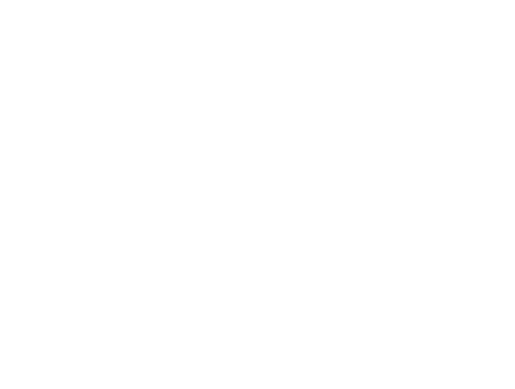

In [ ]:
# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation

best_params = cross_validation_leave_geo_out(all_HSA_ID_weekly_data, geography_column = geography_column, geo_split = geo_split, no_iterations = no_iterations, cv = cv, classifier = clf, param_grid = param_grid, no_iterations_param = no_iterations_param, no_weeks_train = no_weeks_train,no_weeks_test = no_weeks_test, weeks_in_future = weeks_in_future, weight_col = weight_col, keep_output = keep_output, time_period = time_period)
# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test[0], y_pred_proba[:,1])
MCC = (matthews_corrcoef(y_test, y_pred) + 1)/2

print("MCC:", MCC)
print("Accuracy:", accuracy)
print("auROC:", ROC)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf,feature_names=['Cases', 'Admits','Percent Covid'], class_names=['Below', 'Above'], filled=True, impurity=False, proportion=False, rounded=True, precision=3)

In [ ]:
model_name = f"CDC_classifier_auroc_{ROC:.4f}_CDC_period_B.sav"
pickle.dump(clf, open(model_name, 'wb'))

In [124]:
CDC_Classifier_B = pickle.load(open('/Users/rem76/Documents/COVID_projections/COVID_forecasting/Best_models_123_classifier/CDC_classifier_auroc_0.7975_CDC_period_B.sav', 'rb'))
# Train the decision tree classifier
#CDC_Classifier_B.fit(X_train, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = CDC_Classifier_B.predict(X_test)
y_pred_proba_Classifier_B = CDC_Classifier_B.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test[0], y_pred_proba_Classifier_B[:,1])
MCC = (matthews_corrcoef(y_test, y_pred) + 1)/2

print("MCC:", MCC)
print("Accuracy:", accuracy)
print("auROC:", ROC)

MCC: 0.6845376736735236
Accuracy: 0.8783727687837277
auROC: 0.6577385433920594


# Full classifier

In [48]:
# Training 
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_incl_NA.csv")

selected_columns_1 = [col for col in HSA_weekly_data_all.columns if 'week_thirty' in col]
selected_columns_2 = [col for col in HSA_weekly_data_all.columns if 'week_forty' in col]
selected_columns_3 = [col for col in HSA_weekly_data_all.columns if 'week_fifty' in col]
selected_columns_4 = [col for col in HSA_weekly_data_all.columns if 'week_sixty' in col]
selected_columns_5 = [col for col in HSA_weekly_data_all.columns if 'week_seventy' in col]
selected_columns_5 = [col for col in HSA_weekly_data_all.columns if 'week_eighty' in col]


all_HSA_ID_weekly_data_full = HSA_weekly_data_all[selected_columns_1 + selected_columns_2 + selected_columns_3 + selected_columns_4 + selected_columns_5 + ['HSA_ID'] + ['weight']]

In [54]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  
no_weeks_train =  range(1, int(num_of_weeks*2/3) + 1)  # First 6 months initially 
no_weeks_test = range(int(num_of_weeks*2/3) + 1, num_of_weeks -2)  # Next three months
no_iterations_param = 100  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

In [55]:
# Training 
X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data_full,   no_weeks = range(1, int(num_of_weeks*2/3) + 1), weeks_in_future = 3,  geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test_full, y_test_full, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data_full,   no_weeks = range(int(num_of_weeks*2/3) + 1, num_of_weeks-2), weeks_in_future = 3,  geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
weights = weights_full[0]

In [80]:
# Evaluating 
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_incl_NA.csv")

selected_columns_1 = [col for col in HSA_weekly_data_all.columns if 'week_seventy-one' in col]
selected_columns_2 = [col for col in HSA_weekly_data_all.columns if 'week_seventy-two' in col]
selected_columns_3 = [col for col in HSA_weekly_data_all.columns if 'week_seventy-three' in col]
selected_columns_4 = [col for col in HSA_weekly_data_all.columns if 'week_seventy-four' in col]


all_HSA_ID_weekly_data_full = HSA_weekly_data_all[selected_columns_1 + selected_columns_2 + selected_columns_3  + selected_columns_4 + ['HSA_ID'] + ['weight']]

In [82]:
# Evaluating 
X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data_full,   no_weeks = range(71, 74), weeks_in_future = 3,  geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)


In [ ]:
# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation

best_params = cross_validation_leave_geo_out(all_HSA_ID_weekly_data, geography_column = geography_column, geo_split = geo_split, no_iterations = no_iterations, cv = cv, classifier = clf, param_grid = param_grid, no_iterations_param = no_iterations_param, no_weeks_train = no_weeks_train,no_weeks_test = no_weeks_test, weeks_in_future = weeks_in_future, weight_col = weight_col, keep_output = keep_output, time_period = time_period)
# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train_full, y_train_full[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test_full)
y_pred_proba = clf.predict_proba(X_test_full)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test_full, y_pred)
ROC = roc_auc_score(y_test_full, y_pred_proba[:,1])
MCC = (matthews_corrcoef(y_test_full, y_pred) + 1)/2

print("MCC:", MCC)
print("Accuracy:", accuracy)
print("auROC:", ROC)
MCC = (matthews_corrcoef(y_test, y_pred) + 1)/2

print(confusion_matrix(y_test, y_pred))

In [ ]:
#model_name = f"CDC_classifier_auroc_{ROC:.4f}_CDC_period_full.sav"
#pickle.dump(clf, open(model_name, 'wb'))

In [83]:
full_model = pickle.load(open('/Users/rem76/Documents/COVID_projections/COVID_forecasting/CDC_classifier_auroc_0.9091_CDC_period_full.sav', 'rb'))
# Train the decision tree classifier
#full_model.fit(X_train_full, y_train_full[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = full_model.predict(X_test_full)
y_pred_proba_full = full_model.predict_proba(X_test_full)


ValueError: X has 9 features, but DecisionTreeClassifier is expecting 13 features as input.

# Net Benefit for CDC Classifier

In [ ]:
def find_net_benefit(y_probabilities, y_true, omega_sequences):   
    net_benefit_by_omega = {}
    for omega in omega_sequences:
        p = omega/(1 + omega)        
        y_predict_test = np.where(y_probabilities[:, 1] > p, 1, 0)

        tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_predict_test).ravel()


        net_benefit = tp/(len(y_true)) - (fp/(len(y_true)) * omega)

        net_benefit_by_omega[omega] =  net_benefit
    return net_benefit_by_omega

def get_heatmap_data_for_omega_optimal_threshold(NB_data, weeks_to_predict):
        heatmap_data_omega = pd.DataFrame()
        
        for week in range(1, weeks_to_predict[-1]):
                weekly_data = NB_data[week].values()
                #weekly_data = list(reversed(weekly_data))
                heatmap_data_omega[week] = weekly_data
        return heatmap_data_omega
def calculate_gain_data(net_benefit_naive, net_benefit_full, threshold_sequences, weeks_to_predict):
    # Get heatmap data for the naive and full periods
    heatmap_data_naive = get_heatmap_data_for_omega_optimal_threshold(net_benefit_naive, weeks_to_predict)
    heatmap_data_full = get_heatmap_data_for_omega_optimal_threshold(net_benefit_full, weeks_to_predict)
    
    # Calculate gain data
    gain_data = heatmap_data_full.subtract(heatmap_data_naive)
    
    # Add the threshold sequences as an index
    gain_data['threshold_sequences'] = threshold_sequences
    gain_data.set_index('threshold_sequences', inplace=True)
    
    return gain_data

def find_net_benefit_min_negatives(y_probabilities, y_true, omega_sequences):   
    net_benefit_by_omega = {}
    for omega in omega_sequences:
        p = 1/(1 + omega)        
        y_predict_test = np.where(y_probabilities[:, 1] > p, 1, 0)

        tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_predict_test).ravel()


        net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)

        net_benefit_by_omega[omega] =  net_benefit
    return net_benefit_by_omega

In [ ]:
omega_sequences = np.arange(0, 4, 0.01)
NB_positives_Classifier_A = find_net_benefit(y_pred_proba_Classifier_A, y_test, omega_sequences)
#print(NB_positives_Classifier_A)
NB_negatives_Classifier_A = find_net_benefit_min_negatives(y_pred_proba_Classifier_A, y_test, omega_sequences)

NB_positives_naive = find_net_benefit(y_pred_proba_naive, y_test, omega_sequences)
NB_negatives_naive = find_net_benefit_min_negatives(y_pred_proba_naive, y_test, omega_sequences)
#print(NB_positives_naive)

NB_positives_Classifier_B = find_net_benefit(y_pred_proba_Classifier_B, y_test, omega_sequences)
NB_negatives_Classifier_B = find_net_benefit_min_negatives(y_pred_proba_Classifier_B, y_test, omega_sequences)
#print(NB_positives_Classifier_B)

NB_positives_full = find_net_benefit(y_pred_proba_full, y_test_full, omega_sequences)
NB_negatives_full = find_net_benefit_min_negatives(y_pred_proba_full, y_test_full, omega_sequences)
#print(NB_positives_full)





Net benefit of CDC community levels

In [ ]:
TP_CDC_Classifier = sum_high_and_1
FP_CDC_Classifier = sum_med_and_1 + sum_low_and_1
TN_CDC_Classifier = sum_med_and_0 + sum_low_and_0
FN_CDC_Classifier  = sum_high_and_0
total_obs = TP_CDC_Classifier + FP_CDC_Classifier + TN_CDC_Classifier + FN_CDC_Classifier


In [ ]:
NB_positives_CDC_Community = {}
NB_negatives_CDC_Community = {}

for omega in omega_sequences:
    NB_positives_CDC_Community[omega] =  TP_CDC_Classifier/(total_obs) - (FP_CDC_Classifier/(total_obs) * omega)
    NB_negatives_CDC_Community[omega] =  TN_CDC_Classifier/(total_obs) - (FN_CDC_Classifier/(total_obs) * omega)

# Plot net benefit 

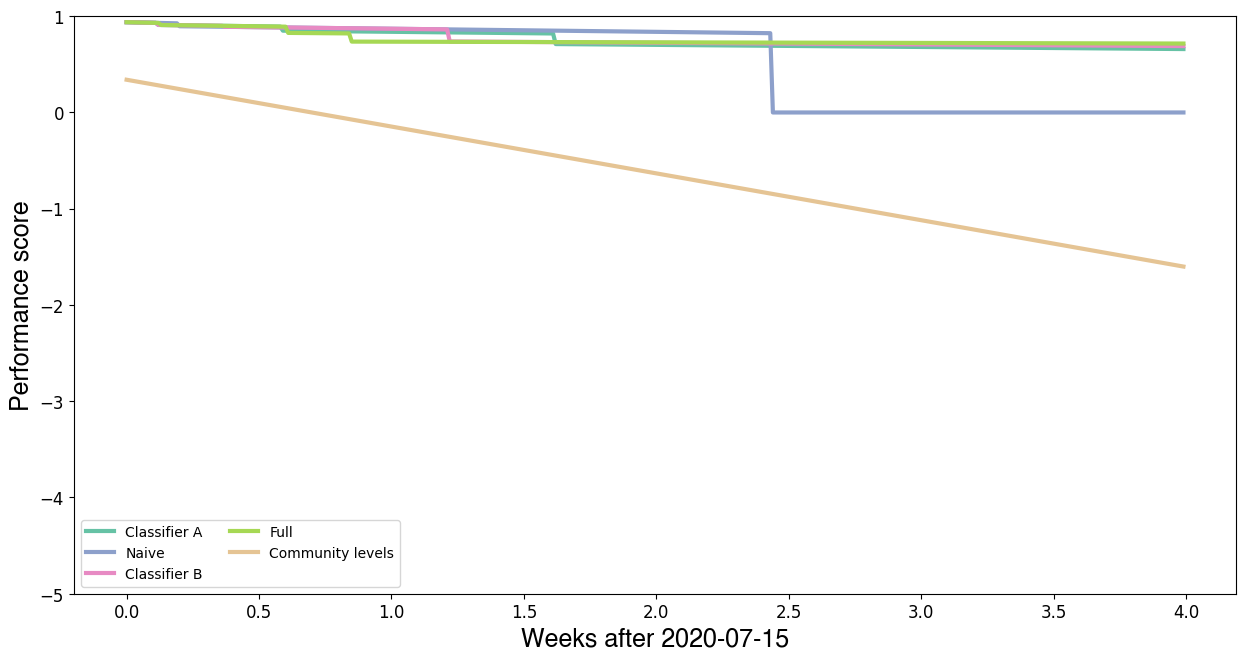

In [ ]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5), sharey = 'all')
# Plot data on the same plot
axs[0].plot(omega_sequences, NB_positives_Classifier_A.values(), label='Classifier A', linewidth = 3, color = palette[0])
axs[0].plot(omega_sequences, NB_positives_naive.values(), label='Naive', linewidth = 3, color = palette[2])
axs[0].plot(omega_sequences, NB_positives_Classifier_B.values(), label='Classifier B', linewidth = 3, color = palette[3])
axs[0].plot(omega_sequences, NB_positives_full.values(), label='Full', linewidth=3, color=palette[4])
axs[0].plot(omega_sequences, NB_positives_CDC_Community.values(), label='Community levels', linewidth=3, color=palette[5])
axs[0].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth=1, color='#A0AABA', linestyle='--')


axs[0].set_ylim(-5,1)
# Add labels and legend
axs[0].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)
axs[0].tick_params(axis='both', which='major', labelsize=12)

#dd_labels_to_subplots(axs, hfont, 1.01, 24)
axs.legend(ncol = 2, loc='lower left')

polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                    alpha=0.3, color = '#cdb4db')
axs.add_patch(polygon_delta)
polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                    alpha=0.3)
axs.add_patch(polygon_omricon)

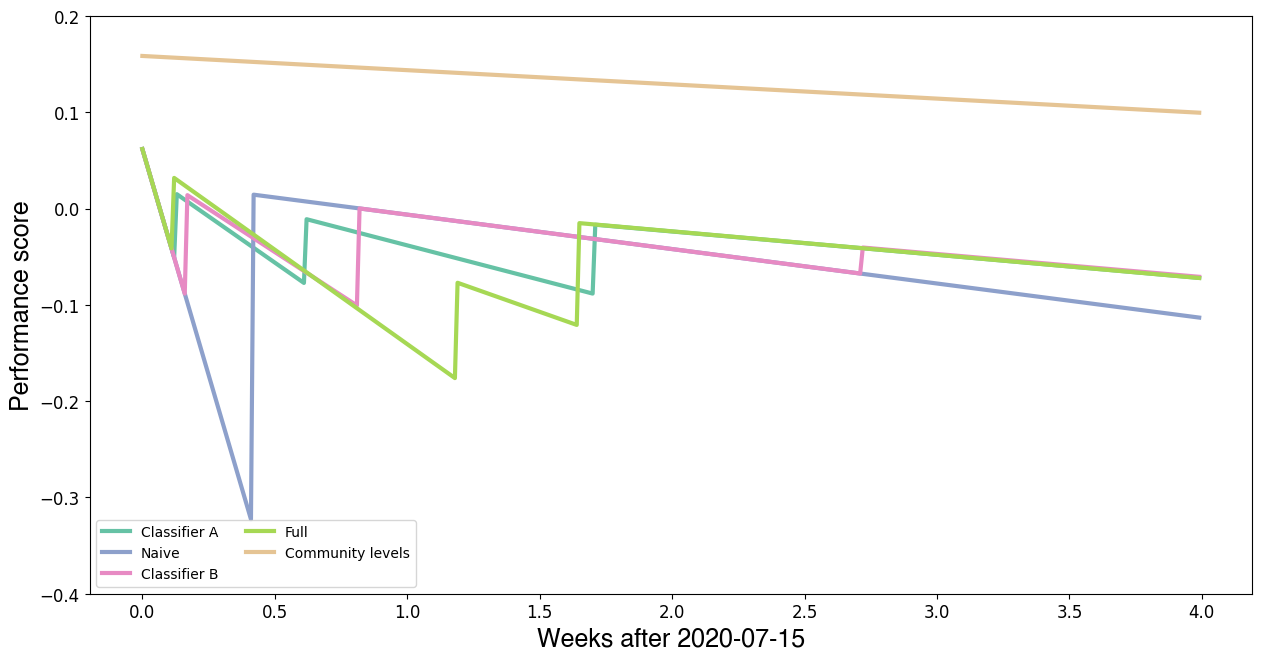

In [ ]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 7.5), sharey = 'all')
# Plot data on the same plot
axs.plot(omega_sequences, NB_negatives_Classifier_A.values(), label='Classifier A', linewidth = 3, color = palette[0])
axs.plot(omega_sequences, NB_negatives_naive.values(), label='Naive', linewidth = 3, color = palette[2])
axs.plot(omega_sequences, NB_negatives_Classifier_B.values(), label='Classifier B', linewidth = 3, color = palette[3])
axs.plot(omega_sequences, NB_negatives_full.values(), label='Full', linewidth=3, color=palette[4])
axs.plot(omega_sequences, NB_negatives_CDC_Community.values(), label='Community levels', linewidth=3, color=palette[5])
#axs.plot(omega_sequences, NB_negatives_CDC_Community.values(), label='MCC', linewidth=3, color=palette[6])

axs.plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth=1, color='#A0AABA', linestyle='--')


axs.set_ylim(-.4,.2)
# Add labels and legend
axs.set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
axs.set_ylabel('Performance score',**hfont,  fontsize = 18)
axs.tick_params(axis='both', which='major', labelsize=12)

#dd_labels_to_subplots(axs, hfont, 1.01, 24)
axs.legend(ncol = 2, loc='lower left')

polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                    alpha=0.3, color = '#cdb4db')
axs.add_patch(polygon_delta)
polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                    alpha=0.3)
axs.add_patch(polygon_omricon)

# Maximum regret

In [ ]:
def calculate_maximum_reget(metric, metrics_by_model, models, time_period, weeks_to_predict):
    metric_data = metrics_by_model[metric]

    maximum_regret_by_model = {model: [] for model in models}
    for j, prediction_week in enumerate(weeks_to_predict):
        best_metric = float('-inf') 

        for i, m in enumerate(metric_data): 
            m = list(metric_data.values())[i]
            model_metric = m[prediction_week]
            if model_metric >= best_metric:
                        best_metric = model_metric

        
        for i, m  in enumerate(metric_data): 
            m = list(metric_data.values())[i]
            model_metric = m[prediction_week]            
            model = models[i]
            if model_metric >= best_metric:
                    maximum_regret_by_model[model].append(0)
            else:
                    maximum_regret_by_model[model].append(best_metric - model_metric)   

    return maximum_regret_by_model

In [ ]:
all_metrics = {}
all_metrics['MCC'] = {'CDC_Community': [0.629], 'CDC_A': [0.682],'CDC_B': [0.715], 'Naive':[0.715], 'Full': [0.694]}
all_metrics['ROC'] = {'CDC_Community':[0.663], 'CDC_A': [0.760],'CDC_B': [0.798], 'Naive': [0.720], 'Full':[0.909]}
all_metrics['accuracy'] = {'CDC_Community':[0.499], 'CDC_A': [.90], 'CDC_B': [0.932], 'Naive': [0.931], 'Full':[0.831]}

models = ['CDC_Community', 'CDC_A', 'CDC_B', 'Naive', 'Full']

In [ ]:
maximum_regret_by_model_MCC =calculate_maximum_reget('MCC', all_metrics, models, time_period, [0])
maximum_regret_by_model_ROC =calculate_maximum_reget('ROC', all_metrics, models, time_period,[ 0])
maximum_regret_by_model_accuracy =calculate_maximum_reget('accuracy', all_metrics, models, time_period, [0])

In [ ]:
maximum_regret_by_model_ROC

{'CDC_Community': [0.246],
 'CDC_A': [0.14900000000000002],
 'CDC_B': [0.11099999999999999],
 'Naive': [0.18900000000000006],
 'Full': [0]}